In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, SimpleRNN, Dense, Dropout, Bidirectional
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [3]:
train_df = pd.read_csv('arxiv_train.csv')
test_df = pd.read_csv('arxiv_test.csv')

In [4]:
train_df.dropna(subset=['abstract', 'label'], inplace=True)
test_df.dropna(subset=['abstract', 'label'], inplace=True)

In [5]:
import re

def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    text = text.lower()
    return text

train_df['clean_abstract'] = train_df['abstract'].apply(clean_text)
test_df['clean_abstract'] = test_df['abstract'].apply(clean_text)


In [6]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'])
y_test = label_encoder.transform(test_df['label'])
num_classes = len(label_encoder.classes_)

### checking if max-words are good

Max length: 432
Mean length: 154.73435
Median length: 150.0


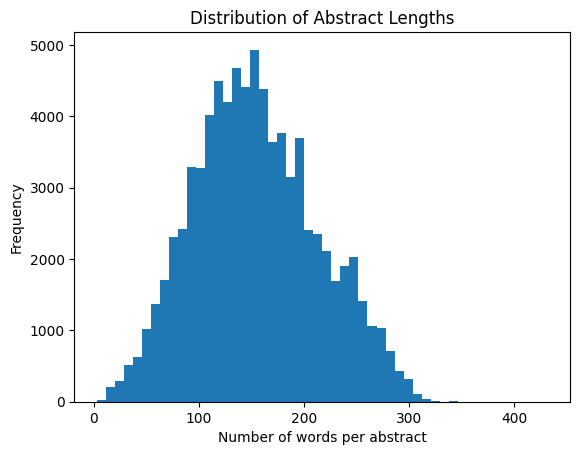

In [7]:
# Number of tokens in each abstract
abstract_lengths = train_df['clean_abstract'].apply(lambda x: len(x.split()))

# Basic stats
print("Max length:", abstract_lengths.max())
print("Mean length:", abstract_lengths.mean())
print("Median length:", abstract_lengths.median())

# Optional: Histogram to visualize
import matplotlib.pyplot as plt

plt.hist(abstract_lengths, bins=50)
plt.xlabel("Number of words per abstract")
plt.ylabel("Frequency")
plt.title("Distribution of Abstract Lengths")
plt.show()


In [8]:
from collections import Counter

# Get all words from the abstracts
all_words = " ".join(train_df['clean_abstract']).split()
word_freq = Counter(all_words)

print("Total unique words:", len(word_freq))

# Look at top N
print(word_freq.most_common(10))


Total unique words: 404114
[('the', 889948), ('of', 508097), ('and', 324780), ('a', 302415), ('in', 268166), ('to', 264902), ('we', 196670), ('is', 159279), ('for', 148360), ('that', 123876)]


In [9]:
# Tokenize the text
max_words = 10000  # Consider top 10,000 words
max_sequence_length = 150  # Truncate or pad abstracts to this length

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df['clean_abstract'])

# Convert text to sequences of indices
X_train_seq = tokenizer.texts_to_sequences(train_df['clean_abstract'])
X_test_seq = tokenizer.texts_to_sequences(test_df['clean_abstract'])

In [10]:
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, BatchNormalization
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2 

model = Sequential([
    # Enhanced embedding
    Embedding(input_dim=max_words, output_dim=64, input_length=max_sequence_length),
    
    # Larger SimpleRNN with regularization
    SimpleRNN(64, activation='tanh', 
              recurrent_regularizer=l2(0.001),
              kernel_regularizer=l2(0.001)),
    
    # Strong regularization to prevent overfitting
    BatchNormalization(),
    Dropout(0.5),
    
    # Hidden layer with regularization
    Dense(48, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    
    # Output layer
    Dense(num_classes, activation='softmax')
])

C:\Users\Alipc\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [58]:
model.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [59]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_simple_rnn_model.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.6,
        patience=1,
        min_lr=0.0001
    )
]

In [60]:
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [61]:
history = model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=64,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 44s 42ms/step - accuracy: 0.1013 - loss: 2.9764 - val_accuracy: 0.1159 - val_loss: 2.4839 - learning_rate: 3.0000e-04
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.1305 - loss: 2.5151 - val_accuracy: 0.1597 - val_loss: 2.4069 - learning_rate: 3.0000e-04
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 0.2139 - loss: 2.3158 - val_accuracy: 0.2265 - val_loss: 2.5616 - learning_rate: 3.0000e-04
Epoch 4/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 46s 46ms/step - accuracy: 0.4426 - loss: 1.6355 - val_accuracy: 0.3579 - val_loss: 1.8462 - learning_rate: 1.8000e-04
Epoch 5/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 52s 52ms/step - accuracy: 0.5867 - loss: 1.2485 - val_accuracy: 0.5214 - val_loss: 1.4262 - learning_rate: 1.8000e-04
Epoch 6/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step - accuracy: 0.6681 - loss: 1.0496 - val_accuracy: 0.6966 - val_loss: 0.9494 - learning_rate: 1.8000e-04
Epoch 7/15
1000/1000 ━━━━━━━━━━━━━━━━━━━

In [62]:
test_loss, test_acc = model.evaluate(X_test_pad, y_test)
print(f"Test accuracy: {test_acc:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7541 - loss: 0.8264
Test accuracy: 0.7545


In [ ]:
y_pred = np.argmax(model.predict(X_test_pad), axis=1)
print("Classification Report:")
print(metrics.classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print(f"Macro F1: {metrics.f1_score(y_test, y_pred, average='macro'):.4f}")
print(f"Weighted F1: {metrics.f1_score(y_test, y_pred, average='weighted'):.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step
Classification Report:
              precision    recall  f1-score   support

    astro-ph       0.92      0.87      0.89      2013
    cond-mat       0.68      0.82      0.74      2058
          cs       0.55      0.54      0.55      1995
        eess       0.65      0.58      0.61      1948
      hep-ph       0.89      0.87      0.88      1990
      hep-th       0.85      0.86      0.86      2019
        math       0.86      0.82      0.84      2042
     physics       0.63      0.52      0.57      1977
    quant-ph       0.83      0.81      0.82      2013
        stat       0.69      0.85      0.76      1945

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.76      0.75      0.75     20000

Macro F1: 0.7518
Weighted F1: 0.7527


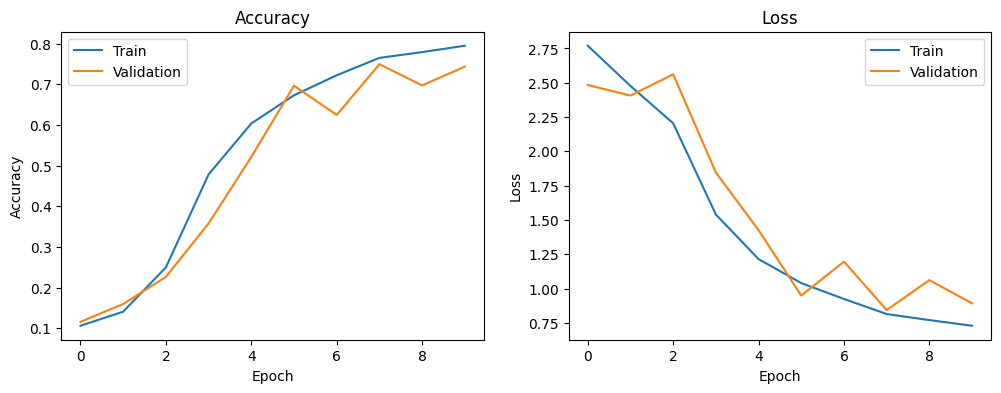

In [64]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# LSTM 

In [84]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras import regularizers
import tensorflow as tf

# LSTM-based model
model_lstm = Sequential([
    Embedding(input_dim=max_words, output_dim=32),
    LSTM(64, return_sequences=False),  # You can try return_sequences=True + more layers
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

In [85]:
model_lstm.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [86]:
callbacks_lstm = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_lstm_model.keras',
        monitor='val_accuracy',
        save_best_only=True
    )
]

In [87]:
history_lstm = model_lstm.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1,
    callbacks=callbacks_lstm
)


Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 381s 175ms/step - accuracy: 0.2672 - loss: 1.8374 - val_accuracy: 0.4856 - val_loss: 1.2041
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 282s 141ms/step - accuracy: 0.5356 - loss: 1.2043 - val_accuracy: 0.5956 - val_loss: 1.1829
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 137s 68ms/step - accuracy: 0.5727 - loss: 1.2026 - val_accuracy: 0.6263 - val_loss: 1.0510
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 137s 68ms/step - accuracy: 0.6421 - loss: 1.0241 - val_accuracy: 0.6948 - val_loss: 0.8951
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 139s 70ms/step - accuracy: 0.7045 - loss: 0.8746 - val_accuracy: 0.7220 - val_loss: 0.8276
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 137s 68ms/step - accuracy: 0.7575 - loss: 0.7511 - val_accuracy: 0.7399 - val_loss: 0.7968
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 138s 69ms/step - accuracy: 0.7943 - loss: 0.6695 - val_accuracy: 0.7793 - val_loss: 0.7068
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 137s 69ms/step - accuracy

In [88]:
test_loss_lstm, test_acc_lstm = model_lstm.evaluate(X_test_pad, y_test)
print(f"LSTM Test accuracy: {test_acc_lstm:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.7984 - loss: 0.6630
LSTM Test accuracy: 0.7977


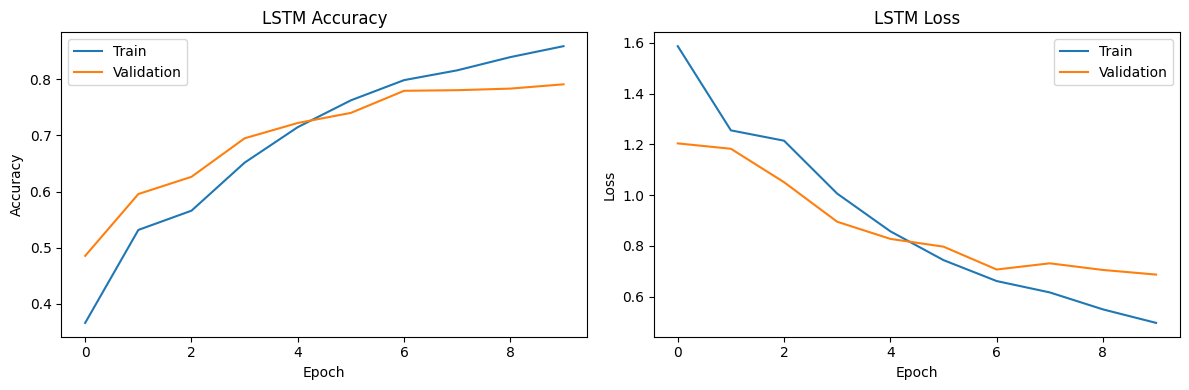

In [89]:
import matplotlib.pyplot as plt

# Plot training history for LSTM model
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Train')
plt.plot(history_lstm.history['val_accuracy'], label='Validation')
plt.title('LSTM Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Train')
plt.plot(history_lstm.history['val_loss'], label='Validation')
plt.title('LSTM Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


# GRU

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras import regularizers
import tensorflow as tf

# Cleaner GRU model
model_gru = Sequential([
    Embedding(input_dim=max_words, output_dim=64),
    GRU(192 , dropout=0.3, return_sequences=False),  # only dropout, no recurrent_dropout
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_gru.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_gru = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_gru_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=0.0001
    )
]

history_gru = model_gru.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    verbose=1,
    callbacks=callbacks_gru
)

# Evaluation
test_loss_gru, test_acc_gru = model_gru.evaluate(X_test_pad, y_test)
print(f"Tuned GRU Test accuracy: {test_acc_gru:.4f}")


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 300s 295ms/step - accuracy: 0.2635 - loss: 1.9231 - val_accuracy: 0.6824 - val_loss: 0.8699 - learning_rate: 5.0000e-04
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 342s 342ms/step - accuracy: 0.6863 - loss: 0.8669 - val_accuracy: 0.7556 - val_loss: 0.7261 - learning_rate: 5.0000e-04
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 294s 294ms/step - accuracy: 0.7793 - loss: 0.6773 - val_accuracy: 0.7664 - val_loss: 0.6926 - learning_rate: 5.0000e-04
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 279s 279ms/step - accuracy: 0.8067 - loss: 0.6034 - val_accuracy: 0.7808 - val_loss: 0.6594 - learning_rate: 5.0000e-04
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 277s 276ms/step - accuracy: 0.8292 - loss: 0.5447 - val_accuracy: 0.7717 - val_loss: 0.6912 - learning_rate: 5.0000e-04
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 284s 284ms/step - accuracy: 0.8386 - loss: 0.5174 - val_accuracy: 0.7802 - val_loss: 0.6793 - learning_rate: 5.0000e-04
Epoch 7/10
1000/1000 ━━━━━━━

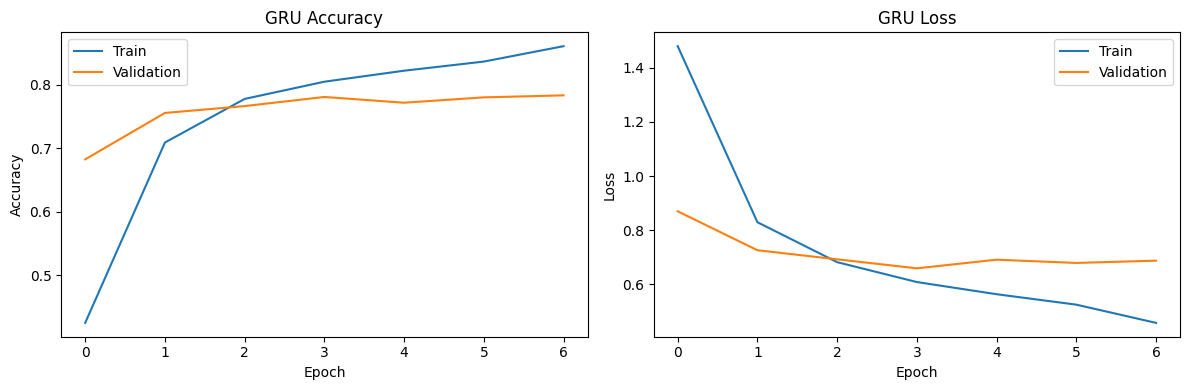

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_gru.history['accuracy'], label='Train')
plt.plot(history_gru.history['val_accuracy'], label='Validation')
plt.title('GRU Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_gru.history['loss'], label='Train')
plt.plot(history_gru.history['val_loss'], label='Validation')
plt.title('GRU Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


# bi RNN

In [128]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras import regularizers
import tensorflow as tf


model_bidir_rnn = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=max_sequence_length),
    Bidirectional(SimpleRNN(32, activation='tanh',
                             recurrent_regularizer=l2(0.001),
                             kernel_regularizer=l2(0.001))),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])


In [129]:
model_bidir_rnn.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [130]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_simple_rnn_model.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-5
    )
]

In [131]:
history = model_bidir_rnn.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=64,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 56s 53ms/step - accuracy: 0.1342 - loss: 2.6412 - val_accuracy: 0.2629 - val_loss: 2.0440 - learning_rate: 3.0000e-04
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 62s 62ms/step - accuracy: 0.4095 - loss: 1.7092 - val_accuracy: 0.6097 - val_loss: 1.2185 - learning_rate: 3.0000e-04
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 71s 71ms/step - accuracy: 0.6498 - loss: 1.1289 - val_accuracy: 0.6820 - val_loss: 1.0286 - learning_rate: 3.0000e-04
Epoch 4/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 77s 77ms/step - accuracy: 0.7265 - loss: 0.9222 - val_accuracy: 0.5768 - val_loss: 1.4756 - learning_rate: 3.0000e-04
Epoch 5/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 76s 76ms/step - accuracy: 0.7732 - loss: 0.8002 - val_accuracy: 0.7094 - val_loss: 1.0144 - learning_rate: 3.0000e-04
Epoch 6/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 76s 75ms/step - accuracy: 0.8031 - loss: 0.7173 - val_accuracy: 0.6249 - val_loss: 1.2721 - learning_rate: 3.0000e-04
Epoch 7/15
1000/1000 ━━━━━━━━━━━━━━━━━━━

In [132]:
test_loss, test_acc_bi_rnn = model_bidir_rnn.evaluate(X_test_pad, y_test)
print(f"Test accuracy: {test_acc:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.7577 - loss: 0.8617
Test accuracy: 0.7545


In [133]:
y_pred = np.argmax(model_bidir_rnn.predict(X_test_pad), axis=1)
print("Classification Report:")
print(metrics.classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print(f"Macro F1: {metrics.f1_score(y_test, y_pred, average='macro'):.4f}")
print(f"Weighted F1: {metrics.f1_score(y_test, y_pred, average='weighted'):.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step
Classification Report:
              precision    recall  f1-score   support

    astro-ph       0.90      0.90      0.90      2013
    cond-mat       0.77      0.72      0.74      2058
          cs       0.65      0.56      0.60      1995
        eess       0.60      0.81      0.69      1948
      hep-ph       0.78      0.92      0.85      1990
      hep-th       0.81      0.85      0.83      2019
        math       0.89      0.71      0.79      2042
     physics       0.56      0.65      0.60      1977
    quant-ph       0.90      0.69      0.78      2013
        stat       0.82      0.73      0.77      1945

    accuracy                           0.75     20000
   macro avg       0.77      0.75      0.76     20000
weighted avg       0.77      0.75      0.76     20000

Macro F1: 0.7552
Weighted F1: 0.7558


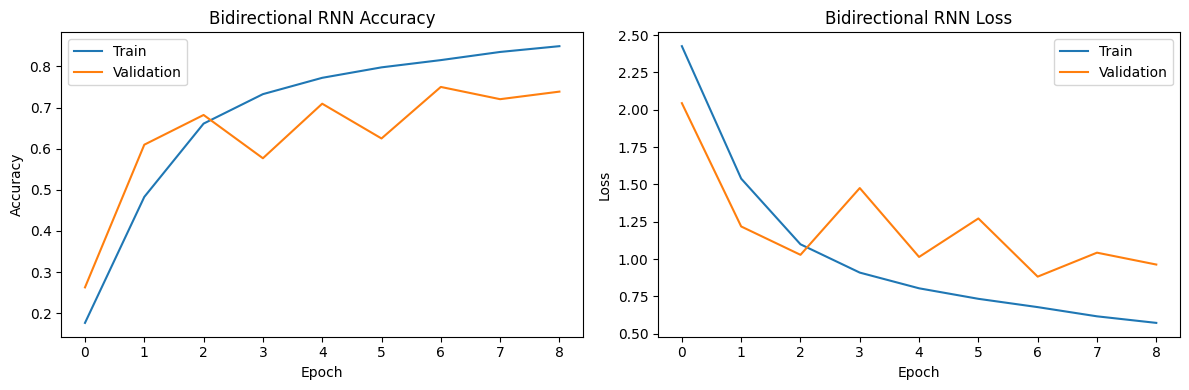

In [134]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Bidirectional RNN Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Bidirectional RNN Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


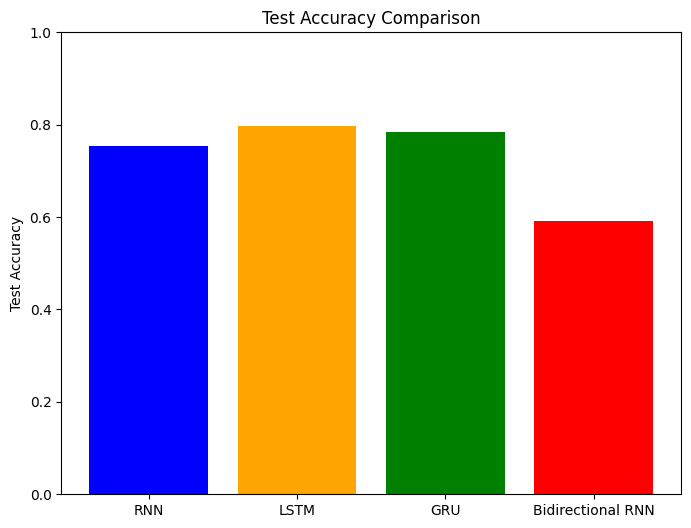

In [119]:

test_accuracies = [test_acc, test_acc_lstm, test_acc_gru, test_acc_bi_rnn]
model_names = ['RNN', 'LSTM', 'GRU', 'Bidirectional RNN']

plt.figure(figsize=(8, 6))
plt.bar(model_names, test_accuracies, color=['blue', 'orange', 'green', 'red'])
plt.title('Test Accuracy Comparison')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1) 
plt.show()
